# Collaborative filtering notebook

Collaborative filtering is an umbrella of methods. These filtering methods only use ratings (implicit or
explicit) as the source for creating recommendations. 

Neighborhood-based filtering is a branch of collaboratie filtering.
User-user and item-item systems are to possible implementations.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn import neighbors
from sklearn.cluster import KMeans
from scipy import sparse
import dask.dataframe as dd
import seaborn as sns
import pickle

In [3]:
# importing movies dataframe
movies = pd.read_csv("data/movies.csv")

# extracting release year
movies['release_year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.release_year = pd.to_datetime(movies.release_year, format='%Y')

# as there are some NaN years, we remove those
movies.dropna(inplace=True) 
movies.release_year = movies.release_year.dt.year 
movies.title = movies.title.str[:-7]
print(movies.info())
movies.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27256 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieId       27256 non-null  int64 
 1   title         27256 non-null  object
 2   genres        27256 non-null  object
 3   release_year  27256 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.0+ MB
None


,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


## Calculating the suggestins for the "cold-starters"

New items won’t show up in any of the non-personali zed recommendations because they don’t have the numbers to enter into sales statistics, and they won’t appear in
personalized recommendations because the system doesn’t know how to relate those to other items. 

Under the umbrella of cold-start problems are also gray sheep. These are users who have such individual tastes that even if there’s data, there are no other users who’ve bought any of the products they have.

When you have enough information to display a recommendation is a tradeoff. It’s a matter of deciding whether you want to display high-quality recommendations when you’ve more data or lower-quality recommendations with less data. Think about it this way: what’s the least amount of data that will suffice for determining someone’s preferences? In certain cases, this could be five ratings, like on a movie site, but in other places, it could be different.

Knowing IP address, gender, anything about the user taht can be used for categorization, can in pricinciple be used to personalize the recommendations from the very begining. We are not going in to this.

It’s often better to recommend something that’s a little off instead of providing no recommendation at all. 

In hybrid recommenders, there is a certain type called mixed hybrids. When such a recommender is used, it falls back to the most popular recommendations if personalized recommendations aren’t available.

We do not have information about what is (or rathe what has been trending in 2015) trending without doing extra work. So we just propose some selection of the "good" and "most" recent movies.

### Some analysis

In [7]:
# selecting only "recently" released movies (in 2014 and 2015)
start_date = 2013
end_date = 2016
mask = (movies['release_year'] > start_date) & (movies['release_year'] <= end_date)
latest_movies = movies.loc[mask]

In [9]:
# import the ratings matrix
ratings = pd.read_csv("data/ratings.csv")
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [10]:
# using Dask library, convert the timestamps to year, month and date
dask_ratings = dd.from_pandas(ratings, npartitions=40)
dask_ratings['rating_year']=dd.to_datetime(ratings.timestamp,unit='s').dt.year
dask_ratings['rating_month']=dd.to_datetime(ratings.timestamp,unit='s').dt.month
dask_ratings['rating_date'] = dd.to_datetime(ratings.timestamp, unit='s')

In [11]:
# compute back the pandas ratings dataframe
ratings = dask_ratings.compute()

In [12]:
# merge latest movies and ratings
latest_ratings = pd.merge(ratings, latest_movies, on="movieId")
latest_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42349 entries, 0 to 42348
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   userId        42349 non-null  int64         
 1   movieId       42349 non-null  int64         
 2   rating        42349 non-null  float64       
 3   timestamp     42349 non-null  int64         
 4   rating_year   42349 non-null  int64         
 5   rating_month  42349 non-null  int64         
 6   rating_date   42349 non-null  datetime64[ns]
 7   title         42349 non-null  object        
 8   genres        42349 non-null  object        
 9   release_year  42349 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 3.6+ MB


Ideally, I would implement a "sliding window" of some months in hte past from "now", within which the popularity of movies is also weithed by the exact release date (newer the movies, higher the weight).
But we can only work with movies of either the beginning of the 2015 year, and/or the movies of from the 2014 year. So we cannot really capture the novelty without implementing extra steps.

In [13]:
# The illustration of the problem due to inability to know the exact date of movie arrival in to the system; the resulating data set is very unbalanced: too little movies from 2015.
# distribution of movies between 2014 and 2015
tempdf = latest_ratings.groupby(['release_year']).agg({'release_year': 'count', 'rating' : ['mean']})
tempdf.head(100)

,release_year,rating
,count,mean
release_year,,
2014,41353,3.524484
2015,996,2.920181


In [20]:
#get the most "popular" movies from this list. by "popular" we define the movies thats been rated a lot and highly.
tmpdf = pd.DataFrame(latest_ratings.groupby(['movieId']).agg({'movieId' : 'count', 'rating': 'mean', 'title': pd.Series.mode,  'release_year': pd.Series.mode}).rename(columns= {'movieId': 'rating_amount', 'rating':'avg_rating'}))
tmpdf.sort_values(by=["rating_amount", "avg_rating"],ascending=False).head(10)

,rating_amount,avg_rating,title,release_year
movieId,,,,
109374,2230,3.992152,"Grand Budapest Hotel, The",2014
112852,2049,3.854807,Guardians of the Galaxy,2014
109487,1739,4.023864,Interstellar,2014
111759,1666,3.843637,Edge of Tomorrow,2014
111362,1534,3.823664,X-Men: Days of Future Past,2014
112556,1479,3.936444,Gone Girl,2014
110102,1261,3.710944,Captain America: The Winter Soldier,2014
108932,1181,3.750635,The Lego Movie,2014
112290,913,3.853231,Boyhood,2014


In [23]:
# Create a list of "popular" movies: select only the movies that have been rated more than 10 times and with the average rating higher then 3.5
mask = (tmpdf['rating_amount'] > 10) & (tmpdf['avg_rating'] > 3.0)
tmpdf2 = tmpdf.loc[mask]
tmpdf2.sort_values(by=["rating_amount", "avg_rating"],ascending=False).head()

,rating_amount,avg_rating,title,release_year
movieId,,,,
109374,2230,3.992152,"Grand Budapest Hotel, The",2014
112852,2049,3.854807,Guardians of the Galaxy,2014
109487,1739,4.023864,Interstellar,2014
111759,1666,3.843637,Edge of Tomorrow,2014
111362,1534,3.823664,X-Men: Days of Future Past,2014


In [24]:
# See the distribution of the movies in the obtained "popularity" list by year. We can see that using this approach we will not be able to recommend the most recent movies released in 2015. 
# Either because they are not often, or highly rated.
tmpdf2.groupby("release_year").count().head()

,rating_amount,avg_rating,title
release_year,,,
2014,186,186,186
2015,9,9,9


In [26]:
#Best movies of 2015 so far:
tmpdf2[tmpdf2.release_year == 2015].sort_values(by=["avg_rating","rating_amount"], ascending=False).head(10)

,rating_amount,avg_rating,title,release_year
movieId,,,,
127098,35,3.800000,Louis C.K.: Live at The Comedy Store,2015
119145,159,3.632075,Kingsman: The Secret Service,2015
129428,21,3.571429,The Second Best Exotic Marigold Hotel,2015
129354,28,3.428571,Focus,2015
130073,21,3.404762,Cinderella,2015
120466,39,3.346154,Chappie,2015
120637,13,3.346154,Blackhat,2015
130490,25,3.240000,Insurgent,2015
128488,20,3.225000,Wild Card,2015


In [30]:
#Best movies of 2014 so far:
tmpdf2[tmpdf2.release_year == 2014].sort_values(by=["rating_amount","avg_rating"], ascending=False).head(10)

,rating_amount,avg_rating,title,release_year
movieId,,,,
109374,2230,3.992152,"Grand Budapest Hotel, The",2014
112852,2049,3.854807,Guardians of the Galaxy,2014
109487,1739,4.023864,Interstellar,2014
111759,1666,3.843637,Edge of Tomorrow,2014
111362,1534,3.823664,X-Men: Days of Future Past,2014
112556,1479,3.936444,Gone Girl,2014
110102,1261,3.710944,Captain America: The Winter Soldier,2014
108932,1181,3.750635,The Lego Movie,2014
112290,913,3.853231,Boyhood,2014


### Testing cold starter function

In [40]:
# Lets say we want to show a list with 50/50 distribution between the release year.
# The formular proposed by Hamid (adapted to my notations):
def cold_starters(df, amount = 10):
    def Min_Max(obj):
        nor_obj = (obj - obj.min()) / (obj.max() - obj.min()) # the denominator always equals one
        return nor_obj
    df['score'] = Min_Max(df.avg_rating) + Min_Max(df.rating_amount) + Min_Max(df.release_year)
    return df.sort_values(by='score', ascending = False).head(10)
    #return Min_Max(df.avg_rating)

In [41]:
cold_starters(tmpdf2, 20)

/tmp/ipykernel_3582/1022972888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = Min_Max(df.avg_rating) + Min_Max(df.rating_amount) + Min_Max(df.release_year)


,rating_amount,avg_rating,title,release_year,score
movieId,,,,,
109374,2230,3.992152,"Grand Budapest Hotel, The",2014,1.654664
127098,35,3.800000,Louis C.K.: Live at The Comedy Store,2015,1.534816
112852,2049,3.854807,Guardians of the Galaxy,2014,1.479701
119145,159,3.632075,Kingsman: The Secret Service,2015,1.476508
109487,1739,4.023864,Interstellar,2014,1.454957
129428,21,3.571429,The Second Best Exotic Marigold Hotel,2015,1.373078
111759,1666,3.843637,Edge of Tomorrow,2014,1.299505
129354,28,3.428571,Focus,2015,1.279090
112556,1479,3.936444,Gone Girl,2014,1.278341


The above formular for calculating the "score" creates a 50/50 mixture of most popular movies in 2014 and 2015.
I think this is it :)

## Implementing the pipeline

* making a pivot matrix
* removing the users bias by normalizing by substracting the mean
* choosing an active user: add myself to the database
* calculating similarity between all active yser and all the rest
* order users by similarity
* select a neighborhood
* predict the rating
* evoluate results (accuracy)

### Geting the utility matrix

In [3]:
# load utility matrix 
util_mat = pd.read_csv('matrices/pivot.csv', index_col='userId')

# load sparce utility matrix 
csr_util_mat = load_npz("matrices/sparse_ratings.npz")

In [42]:
# load utility matrix with NAs
util_mat_na = pd.read_csv('matrices/pivot_na.csv', index_col='userId')

In [43]:
util_mat_na.head()

,1,2,3,4,5,6,7,8,9,10,...,112183,112290,112552,112556,112623,112852,115569,116797,116823,118696
userId,,,,,,,,,,,,,,,,,,,,,
54,4.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,4.0,3.5,3.0,NaN,NaN,NaN,2.5,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,3.0,2.0,2.0,NaN,NaN,1.5,NaN,1.0,1.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ading myself to the database

In [108]:
sveta_ratings = pd.read_csv('matrices/sveta_ratings.csv')
sveta_ratings.tail(50)

,movie_id,imdb_id,tmdb_id,rating,average_rating,title
76,7361,338013,38,5.0,4.06919,Eternal Sunshine of the Spotless Mind (2004)
77,7371,276919,553,5.0,3.85089,Dogville (2003)
78,7438,378194,393,3.5,3.82391,Kill Bill: Vol. 2 (2004)
79,7759,86022,1394,4.5,3.93680,Nostalgia (1983)
80,8644,343818,2048,3.0,3.47179,"I, Robot (2004)"
81,8961,317705,9806,2.5,3.84679,The Incredibles (2004)
82,26150,60107,895,5.0,4.02105,Andrei Rublev (1966)
83,26578,91670,24657,3.0,3.94231,The Sacrifice (1986)
84,32892,56111,31442,3.0,3.92866,Ivan's Childhood (1962)
85,39869,342735,1951,3.0,3.67127,Manderlay (2005)


In [45]:
def add_user(ml_user_ratings, pivot_mat, userId):
    intersection = set(pivot_mat.columns.astype(int)) & set(ml_user_ratings.movie_id)
    if len(intersection) > 0:
        df = pd.DataFrame(columns=pivot_mat.columns, index=[userId])
        df.head()
        pivot_mat = pd.concat([df, pivot_mat])
        for i in intersection:
            entry = ml_user_ratings.loc[ml_user_ratings.movie_id == i]
            movie_rating = entry.rating.values[0]
            pivot_mat.loc[[userId], [str(i)]] = movie_rating
        return pivot_mat
    else:
        return print("Zero intersection")

In [46]:
util_mat_na_new = add_user(sveta_ratings, util_mat_na, 0)

In [47]:
util_mat_na_new.head()

,1,2,3,4,5,6,7,8,9,10,...,112183,112290,112552,112556,112623,112852,115569,116797,116823,118696
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,4.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,4.0,3.5,3.0,NaN,NaN,NaN,2.5,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
hamid_ratings = pd.read_csv('matrices/Hamid-ratings.csv')
hamid_ratings.head()

,movie_id,imdb_id,tmdb_id,rating,average_rating,title
0,1,114709,862,4.0,3.89318,Toy Story (1995)
1,6,113277,949,3.5,3.86393,Heat (1995)
2,16,112641,524,3.5,3.82948,Casino (1995)
3,32,114746,63,5.0,3.89622,Twelve Monkeys (1995)
4,47,114369,807,5.0,4.08761,Se7en (1995)


In [48]:
util_mat_na_new = add_user(hamid_ratings, util_mat_na_new, 1)

In [49]:
util_mat_na_new.head()

,1,2,3,4,5,6,7,8,9,10,...,112183,112290,112552,112556,112623,112852,115569,116797,116823,118696
1,4.0,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,4.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,4.0,3.5,3.0,NaN,NaN,NaN,2.5,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalization of the rating matrix

In [50]:
# normalize the item ratings based on the users’ average rating
def csr_mean_normalization(csr_mat):
    """
    Normalizes the sparce utility matrix based on user's mean rating
    """
    csr_mean = csr_mat.sum(axis=1).flatten()/csr_mat.getnnz(axis=1)
    mean_user_vector = np.asarray(csr_mean)
    # TODO: figure out how to do minus means on this kind of structure
    return mean_user_vector[0]

def mean_normalization(pivot):
    mat = pivot.copy()
    averages = mat[mat != 0].mean(axis = 1).values
    for i in range(len(mat)):
        # Subtract by mean of each user, not the entire user
        mat.iloc[i,:] = (mat.iloc[i,:] - averages[i]) 
    return averages, mat

In [51]:
means, pivot_norm_na = mean_normalization(util_mat_na_new)
pivot_norm_na.head()

,1,2,3,4,5,6,7,8,9,10,...,112183,112290,112552,112556,112623,112852,115569,116797,116823,118696
1,0.380282,NaN,NaN,NaN,NaN,-0.119718,NaN,NaN,NaN,NaN,...,0.380282,NaN,NaN,NaN,NaN,0.380282,0.380282,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.818627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,0.557143,-0.442857,NaN,NaN,-0.442857,-0.442857,NaN,NaN,NaN,0.557143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,0.859034,NaN,NaN,NaN,NaN,0.359034,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,0.594295,0.094295,-0.405705,NaN,NaN,NaN,-0.905705,NaN,NaN,0.594295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
means[0]

3.619718309859155

In [114]:
# fillna(0) should come after scaling
pivot_norm = pivot_norm_na.fillna(0)
pivot_norm.head(20)

,1,2,3,4,5,6,7,8,9,10,...,112183,112290,112552,112556,112623,112852,115569,116797,116823,118696
1,0.380282,0.000000,0.000000,0.000000,0.000000,-0.119718,0.000000,0.000000,0.000000,0.000000,...,0.380282,0.0,0.000000,0.0,0.0,0.380282,0.380282,0.0,0.0,0.0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.818627,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
54,0.557143,-0.442857,0.000000,0.000000,-0.442857,-0.442857,0.000000,0.000000,0.000000,0.557143,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
58,0.859034,0.000000,0.000000,0.000000,0.000000,0.359034,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
91,0.594295,0.094295,-0.405705,0.000000,0.000000,0.000000,-0.905705,0.000000,0.000000,0.594295,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
116,0.813469,-0.186531,-0.186531,0.000000,0.000000,-0.686531,0.000000,-1.186531,-0.686531,-0.186531,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
134,0.815789,0.000000,0.000000,0.000000,0.000000,-0.184211,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
156,1.286312,1.286312,-1.713688,-0.713688,-0.713688,0.286312,0.286312,0.000000,-0.713688,0.286312,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
208,0.324752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


### Similarity matrix using pairwise cosine similarity
To measure the similarity of users from the utility matrix, we can use the Cosine Distance method, which calculates the angle between the ratings of different users. In this method, we treat the blank entries as zero. One thing to note about this method is that it latently treats the lack of a rating as disliking the movie (i.e. rating = 0) (Ullman et al., 2014).

We will be using the cosine_similarity function from the sklearn library. We will implement collaborative filtering using cosine similarity.
We can compute pairwise cosine similarity on the rows of a sparse matrix directly using sklearn.

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

In [59]:
pivot_norm_sparse = sparse.csr_matrix(pivot_norm)
pivot_norm_sparse

<6586x4476 sparse matrix of type '<class 'numpy.float64'>'
	with 5343448 stored elements in Compressed Sparse Row format>

In [66]:
start = time.time()
similarities = cosine_similarity(pivot_norm_sparse)
end = time.time()
print('Similarity matrix calculation took', end - start, 'seconds')
#print('pairwise dense output:\n {}\n'.format(similarities))

Similarity matrix calculation took 32.44875955581665 seconds


In [60]:
similarities_sparse = cosine_similarity(pivot_norm_sparse, dense_output=False)
#print('pairwise dense output:\n {}\n'.format(similarities_sparse))

Has the length of number of users, which is correct. however, the user id are lost in this representation
We can precompute the matrux and save it. It will not correspond to the production conditions (in production ratings matrix is updated contantly), but for the demotration purposes it 

In [61]:
def return_similarity(user_index, similarity_mat):
    """
    return cosine similarity for user with the index ``user_index`` based on the precomputed similarity matrix.
    """
    
    similarity_list = []
    for i, sim in enumerate(similarity_mat[user_index, :]):
        if sim == similarity_mat[user_index, user_index]:
            continue
        similarity = {
            'user_index': i,
            'cosine_similarity': round(sim, 3)
        }
        similarity_list.append(similarity)

    return similarity_list

#return_similarity(1, similarities)

In [103]:
def plot_rating(expected_dict, idx):
    title = expected_dict.keys()
    rating = expected_dict.values()
    recommended = []
    for score in rating:
        if score > 0:
            recommended.append(True)
        else:
            recommended.append(False)
            
    df = pd.DataFrame({
        "Title": title, 
        "Expected Rating": rating, 
        "Recommended": recommended
    }).sort_values(by = "Expected Rating", ascending = False)
    plt.figure(figsize=(20, 7))
    plt.xticks(rotation=90)
    plt.title("Predicted Rating for Unwatched Movies and Recommendation")
    
    # return the plot and a dataframe of the top 10 recommended movies
    return (sns.barplot(x = "Title", y = "Expected Rating", hue = "Recommended", data = df.iloc[:50,:]), df.iloc[:50,:])

In [63]:
def get_movie_titles_by_ids(ids, movie_df):
    titles = []
    for i in ids.astype(int):
        title = movie_df[movie_df.movieId == i].title
        titles.append(title)
    return titles

In [109]:
def get_predicted_ratings(userId, mat, similarity_mat, means):
    current_rating = np.array([mat.loc[userId,:]]).reshape(-1, 1)
    
    # BASE CASE: if the user has watched all movies, then returns nothing.
    if 0 not in current_rating: 
        print("This user has watched all the movies.")
        return -1

    # get user index in the matrix
    user_index = np.where(mat.index == userId)[0][0]
    
    print('user index in pivot is', user_index)
    
    # get similrities for this user
    similarity_list = return_similarity(user_index, similarity_mat)
    # use only certain number of closest users to avaoid calculation of the all ratings
    similarity_list = sorted(similarity_list, key=lambda x: x['cosine_similarity'], reverse=True)[:400]
    
    movie_ids = mat.columns
    movie_titles = get_movie_titles_by_ids(movie_ids, movies)
    
    ratings = current_rating[0].tolist()
    expected_dict = dict()
    for n, movie_id in enumerate(movie_ids):
        rating = mat.loc[userId, movie_id]
        
        # skip if the user has already seen a movie
        if rating != 0: 
            continue

        numerator = 0
        denominator = 0        
        for similarity in similarity_list:
            other_idx = similarity['user_index']
            other_similarity = similarity['cosine_similarity']
            other_user_rating = mat.iloc[other_idx, n]
            
            # we do not consider the similarity of unwatched users 
            # because it only affects the denominator but not numerator
            if other_user_rating == 0: 
                continue

            # numerator is iteratively adding up each rating x each similarity score
            numerator = numerator + (other_user_rating * other_similarity)
            denominator += other_similarity

        if denominator == 0: # avoid zero division error
            expected_rating = 0
        else:
            expected_rating = round(numerator / denominator, 3) + means[user_index]

        expected_dict[movie_titles[n].values[0]] = expected_rating

    return expected_dict, user_index

In [110]:
# compute predicted ratings for Sveta
start = time.time()
ratings_pred, user_index = get_predicted_ratings(0, pivot_norm, similarities, means)
end = time.time()
print('Predicted ratings calculation based on all users took', end - start, 'seconds')

user index in pivot is 1
Predicted ratings calculation based on all users took 40.10173511505127 seconds


(<Axes: title={'center': 'Predicted Rating for Unwatched Movies and Recommendation'}, xlabel='Title', ylabel='Expected Rating'>,
                                                   Title  Expected Rating  \
 1773                                    American Beauty         5.205373   
 2049                              East-West (Est-ouest)         5.167373   
 527   Dr. Strangelove or: How I Learned to Stop Worr...         5.103373   
 3219                       Diabolique (Les diaboliques)         5.089373   
 780                                          Goodfellas         5.080373   
 1672                                              Limbo         5.064373   
 44                                 Seven (a.k.a. Se7en)         5.063373   
 2222                                        Coming Home         5.056373   
 3176  Passion of Joan of Arc, The (Passion de Jeanne...         5.055373   
 772   Good, the Bad and the Ugly, The (Buono, il bru...         5.055373   
 3462                   

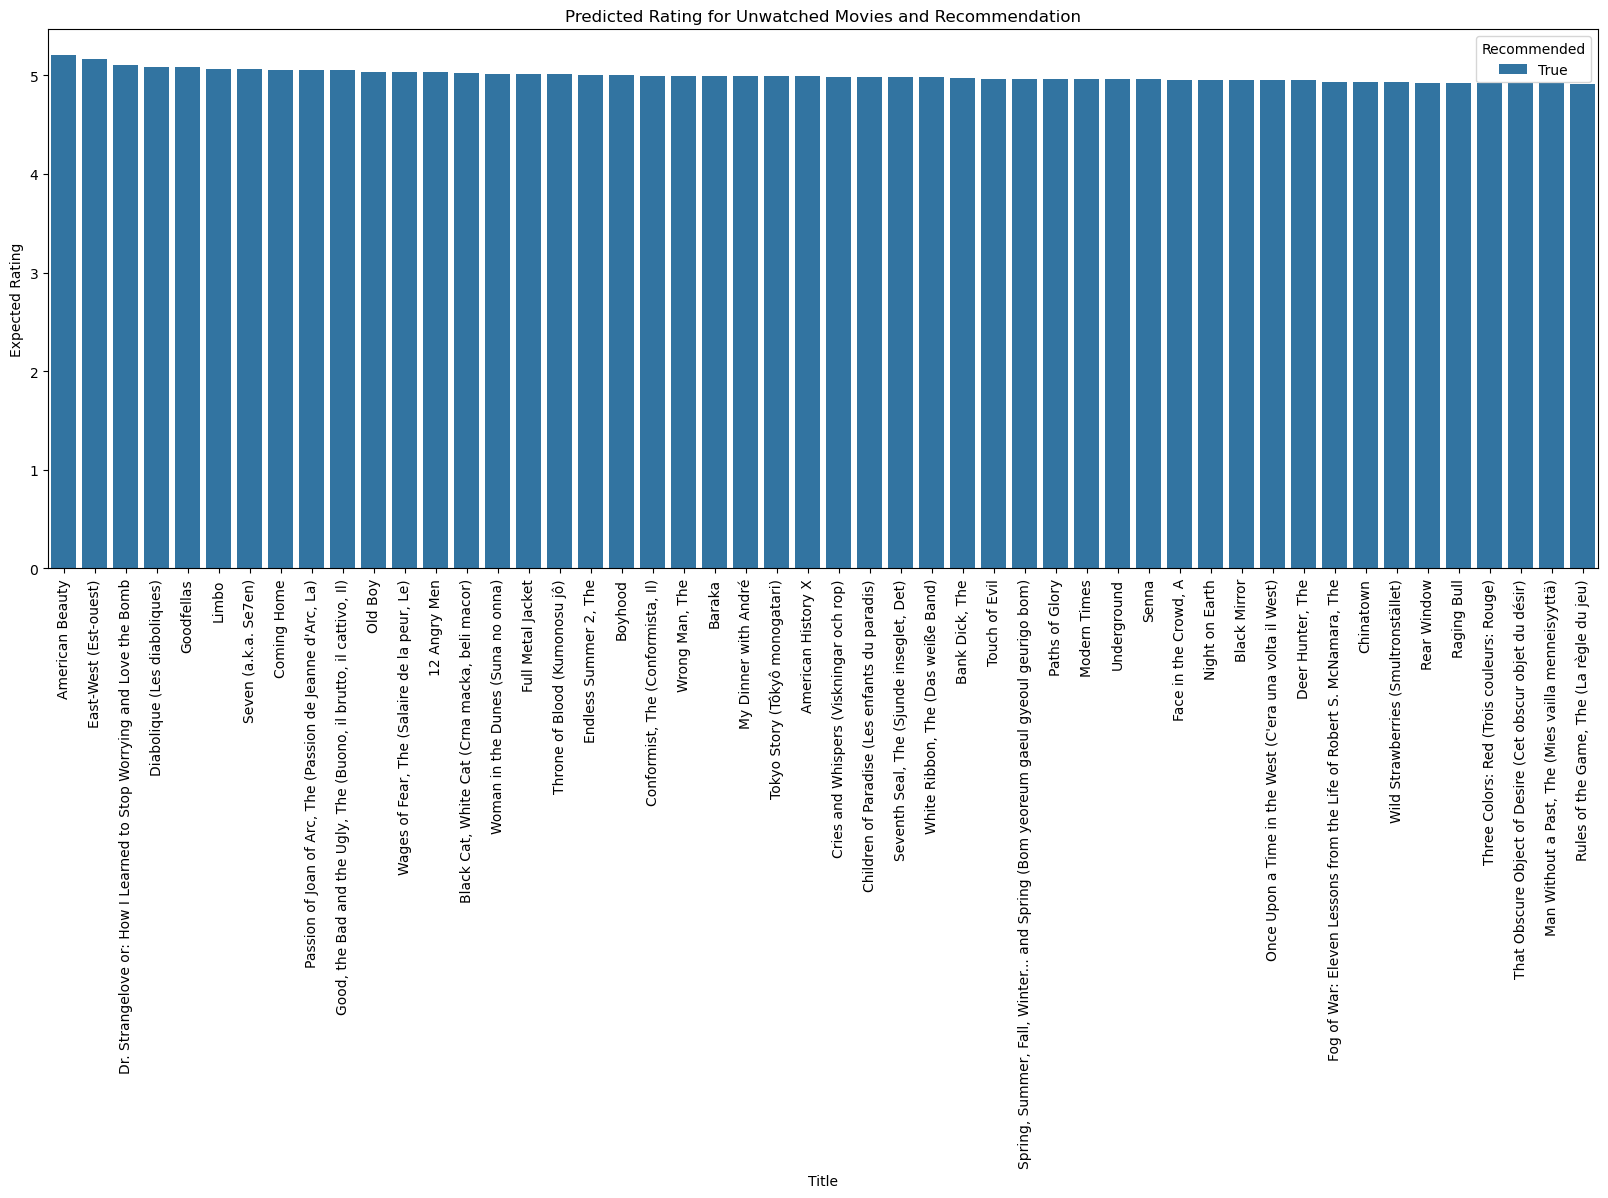

In [111]:
# plot results
plot_rating(ratings_pred, user_index)

user index in pivot is 0
Predicted ratings calculation based on all users took 49.05999732017517 seconds


(<Axes: title={'center': 'Predicted Rating for Unwatched Movies and Recommendation'}, xlabel='Title', ylabel='Expected Rating'>,
                                                   Title  Expected Rating  \
 468                     World of Apu, The (Apur Sansar)         4.831718   
 3114  Passion of Joan of Arc, The (Passion de Jeanne...         4.699718   
 1770      Children of Paradise (Les enfants du paradis)         4.698718   
 3044                                              Ikiru         4.677718   
 757   Once Upon a Time in the West (C'era una volta ...         4.668718   
 1252                             Trip to Bountiful, The         4.661718   
 1251          Fanny and Alexander (Fanny och Alexander)         4.658718   
 467           Song of the Little Road (Pather Panchali)         4.654718   
 3035                     Tokyo Story (Tôkyô monogatari)         4.647718   
 794                                                   M         4.636718   
 752   Good, the Bad and

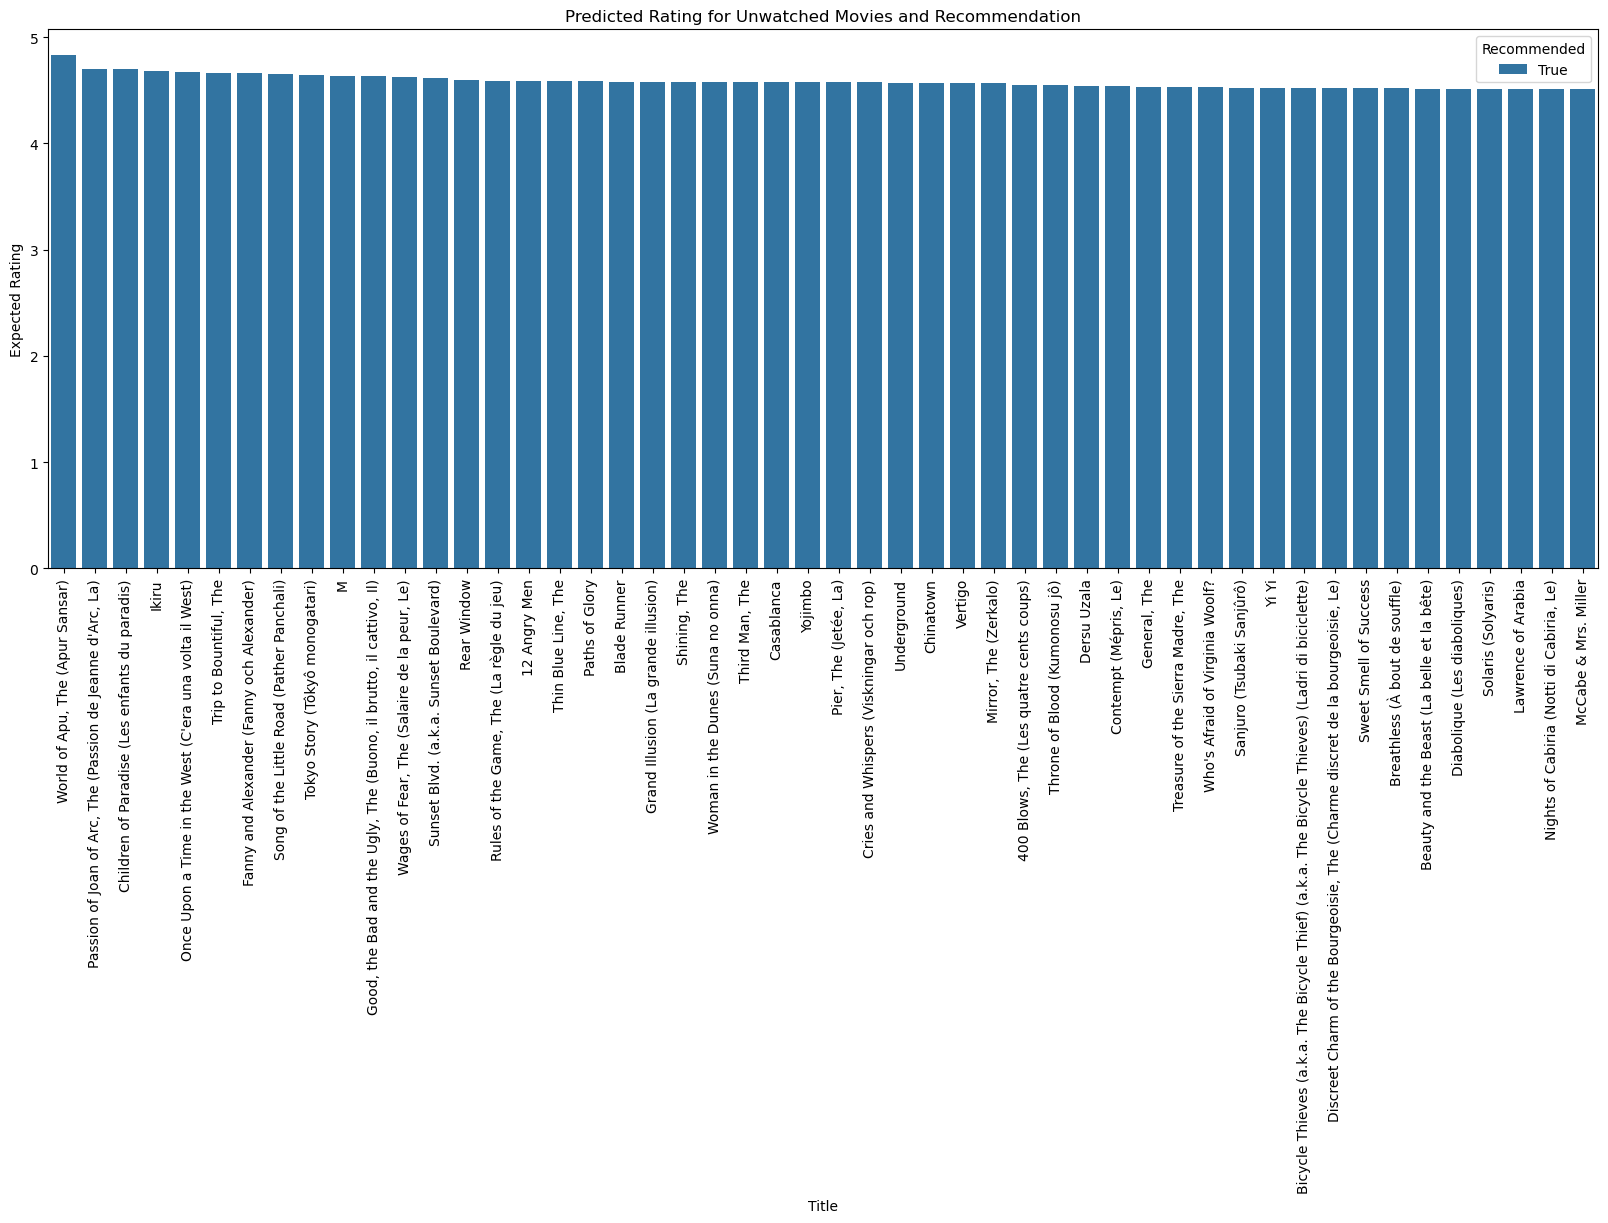

In [116]:
# compute predicted ratings for Hamid
start = time.time()
ratings_pred, user_index = get_predicted_ratings(1, pivot_norm, similarities, means)
end = time.time()
print('Predicted ratings calculation based on all users took', end - start, 'seconds')
plot_rating(ratings_pred, user_index)

Computation of similarity is fast if using the sparse matrix.
However, computation of predisted ratings is really slow : here we compute the ratings for all the movies through looping.
To improve this, I can try:
* consider only N most simlilar users
* compute the ratings based on these users only.

**50 cloasest users:**
It does not recommend me the movies that I watched and liked.

Apart from Pulp Fiction, but not in the first twenty. Why?

**100 cloasest users:**
It does not recommend me the movies that I watched and liked, apart from Pulp Fiction, Pulp Fiction, Fight Club and The Godfather, in the best twenty.

**150 cloasest users:**
Not better

**200 cloasest users:**
More popular movies appear in the list, but still, most of hte films in hte list I do not know.
It relly things I may like the Pumkinghead movie:)

**300 closest users:**

It seems that it would recommend alot of films to me that I watched and rated highly. But those are also among the most popular movies. 

After filtering the films already watched, it sould recommend some films to me that I did not rated, but watched and really liked, but most of the films are unknown to me.

**350 closest users:**

The filtered list seems to be better and better: I recognise more films that I watched, but not rated, and liked.

More and for foreign suggestions, which make sense, as I rated quite some non-americal films, I guess..

**400 closest users:**
A lot of foreign films suggested, when filtered the watched movies.
If the wathed movies are not filtered, it shows mostly popular movies, but some Tarkovsky movies as well, which a good sign.

*the hypothesis:* this methos cannot rely on the low number of closest user, as this selection can be very non-representative. the more users are used to compute the predicted ratings, the more "meaningful" the suggestion are to me personally. Maybe too meanigfull.

**500 closest users:**
It takes about a minute to predict the ratings.
The unfiltered list is mostly the films that I watched and rated highly.
The filtered list is mostly films I dod not know, a maybe too exotic.

**1000 closest users:**
I have a feeling, the suggestions are a bit more interesting, if filtered.

 1773                                    American Beauty         5.181373   
 527   Dr. Strangelove or: How I Learned to Stop Worr...         5.113373   
 3176  Passion of Joan of Arc, The (Passion de Jeanne...         5.094373   
 780                                          Goodfellas         5.082373   
 44                                 Seven (a.k.a. Se7en)         5.027373   
 772   Good, the Bad and the Ugly, The (Buono, il bru...         5.019373   
 3219                       Diabolique (Les diaboliques)         5.015373   
 3095                     Tokyo Story (Tôkyô monogatari)         5.013373   
 774                                        12 Angry Men         5.013373   
 757                                      Paths of Glory         5.011373   
 3298        Wages of Fear, The (Salaire de la peur, Le)         5.009373   
 787                                   Full Metal Jacket         5.006373   
 602                                          Casablanca         4.993373   
 611              Sunset Blvd. (a.k.a. Sunset Boulevard)         4.993373   
 1988                  Woman in the Dunes (Suna no onna)         4.991373   
 1453                                 American History X         4.987373   
 594                                         Rear Window         4.986373   
 2781                Wild Strawberries (Smultronstället)         4.966373   
 3462                                            Old Boy         4.965373   
 779                                      Third Man, The         4.960373   
 823                                    Deer Hunter, The         4.954373   
 813                                           Chinatown         4.954373   
 2099                                       Modern Times         4.948373   
 777   Once Upon a Time in the West (C'era una volta ...         4.946373   
 3104                                              Ikiru         4.939373   
 2536            Cries and Whispers (Viskningar och rop)         4.937373   
 484                                         Underground         4.936373   
 800            Seventh Seal, The (Sjunde inseglet, Det)         4.929373   
 1025                                  L.A. Confidential         4.924373   
 793                                         Raging Bull         4.922373


**all users:**
It took about 11 seconds.
ANd it does not make much sense. the predicted ratings are out of range

3062                            Alex and Emma       366.468373         True
 3566                         Just Like Heaven       298.441373         True
 3986           Dr. Horrible's Sing-Along Blog        90.597373         True
 4245                          Despicable Me 2        79.032373         True
 3100                        Pink Panther, The        71.550373         True
 4241                      Monsters University        69.262373         True
 3998                                 17 Again        50.817373         True
 3912                                Get Smart        50.435373         True
 3032                         Bulletproof Monk        41.467373         True
 3643                        Failure to Launch        41.400373         True
 2650                           Musketeer, The        39.191373         True
 2837         Spirit: Stallion of the Cimarron        38.631373         True
 3346               Chronicles of Riddick, The        37.162373         True
 3039                                 Wiz, The        34.460373         True
 2966                       Star Trek: Nemesis        30.671373         True
 3023                                Core, The        29.472373         True
 4074                 How to Train Your Dragon        28.938373         True
 3850                      Golden Compass, The        22.454373         True
 814            Day the Earth Stood Still, The        21.832373         True
 3515  Miss Congeniality 2: Armed and Fabulous        20.135373         True
 3640                               Date Movie        19.787373         True
 4207              Snow White and the Huntsman        18.867373         True
 2901                Ballistic: Ecks vs. Sever        18.252373         True
 3883                                10,000 BC        15.602373         True
 3042                Lizzie McGuire Movie, The        15.583373         True
 3865      AVPR: Aliens vs. Predator - Requiem        14.209373         True
 3869                               27 Dresses        13.493373         True
 4180                               Real Steel        13.349373         True
 3151                                    Radio        12.765373         True
 2752                                Snow Dogs        12.060373         True)
 
 There is a problem in calculation. If I watched ar the movies in with the predicted rating of 5, it has same items as the list above:
 
 3219                       Diabolique (Les diaboliques)         5.033373   
 3284                                          Fail-Safe         5.029373   
 3298        Wages of Fear, The (Salaire de la peur, Le)         5.029373   
 2084                                   Double Indemnity         5.027373   
 2781                Wild Strawberries (Smultronstället)         5.027373   
 2030                                        City Lights         5.026373   
 891   Paradise Lost: The Child Murders at Robin Hood...         5.025373   
 3311                   High and Low (Tengoku to jigoku)         5.019373   
 3069                   Sinbad: Legend of the Seven Seas         5.016373   
 2099                                       Modern Times         5.013373   
 793                                         Raging Bull         5.012373   
 1879                                            Yojimbo         5.010373   
 1918  Bicycle Thieves (a.k.a. The Bicycle Thief) (a....         5.010373   
 94                                Anne Frank Remembered         5.010373   
 1862                               Being John Malkovich         5.008373   
 835                                      Cool Hand Luke         5.008373   
 3104                                              Ikiru         5.006373   
 808                                       Graduate, The         5.003373   
 823                                    Deer Hunter, The         5.002373   
 777   Once Upon a Time in the West (C'era una volta ...         5.002373   
 598                                  North by Northwest         5.002373   
 3462                                            Old Boy         5.001373   
 593                                             Vertigo         5.000373   
 4007     Night at the Museum: Battle of the Smithsonian         4.996373   
 815                   Treasure of the Sierra Madre, The         4.994373   
 809                                       Touch of Evil         4.994373   
 800            Seventh Seal, The (Sjunde inseglet, Det)         4.993373   
 3975                                         Bride Wars         4.990373   
 790                                             Amadeus         4.990373   
 3125           Rules of the Game, The (La règle du jeu)         4.989373   
 2195                                             Baraka         4.987373   
 794                                          Annie Hall         4.987373   
 1707            400 Blows, The (Les quatre cents coups)         4.984373   
 3604                                     Chicken Little         4.983373   
 1185                                  On the Waterfront         4.976373   
 3304                      Throne of Blood (Kumonosu jô)         4.975373   
 3097                           Kind Hearts and Coronets         4.969373   
 4026                        G.I. Joe: The Rise of Cobra         4.969373   
 4144                                              Senna         4.969373   
 4106                           Resident Evil: Afterlife         4.968373   
 3306                          Babylon 5: A Call to Arms         4.967373   
 2805                                Rashomon (Rashômon)         4.963373   
 783                                                 Ran         4.963373   
 2536            Cries and Whispers (Viskningar och rop)         4.962373   
 612                                       All About Eve         4.962373   
 603                                 Maltese Falcon, The         4.958373   
 1299                                          Peter Pan         4.955373   
 3764                                      Becoming Jane         4.954373   
 752             Cinema Paradiso (Nuovo cinema Paradiso)         4.952373   
 4035                  Cloudy with a Chance of Meatballs         4.951373 

**Question:**
- Using KMeans to find the cluster of the user.
- There should be metric that I can apply to determine the optimal number of closest users.
- I should also implement longtail management.
- How else I could compute the predicted ratings based on similarity?





    


### Evaluation of accuracy

Accuracy is one of the most fundamental measures through which recommender systems are evaluated.

In the most general case, ratings are numeric quantities that need to be estimated. Therefore, the accuracy metrics are often similar to those used in regression modeling. Let R be the ratings matrix in which ruj is the known rating of user u for item j. Consider the case where a recommendation algorithm estimates this rating as r̂uj . Then, the entry-specific error of the estimation is given by the quantity euj = r̂uj − ruj . The overall error is computed by averaging the entry-specific errors either in terms of absolute values or in terms of squared values. 

By the way, many systems do not predict ratings; rather they only output rankings of top-k recommended items. This is particularly common in implicit feedback data sets. Different methods are used to evaluate the accuracy of ratings predictions and the accuracy of rankings. 

Ranking-based measures often focus on the accuracy of only the ranks of the top-k items rather than all the items. This is particularly true in the case of implicit feedback data sets. Even in the case of explicit ratings, the ranking-based evaluations provide a more realistic perspective of the true usefulness of the recommender system because the user only views the top-k items rather than all the items. However, for bench-marking, the accuracy of ratings predictions is generally preferred because of its simplicity. In the Netflix Prize competition, the RMSE measure was used for final evaluation. 

* Designing the accuracy evaluation: 
Collaborative filtering is a direct generalization of the classification and regression modeling problem. Therefore, the standard methods that are used in classification and regression modeling, such as hold-out and cross-validation, are also used in the evaluation of recommendation algorithms.

* Accuracy metrics:
     * Accuracy of estimating ratings: mean squared error, mean absolute error and  root mean squared error
     * Accuracy of estimating rankings: rank-correlation measures

! The main problem with accuracy metrics is that they often do not measure the true effectiveness of a recommender system in real settings.

A common mistake made by analysts in the benchmarking of recommender systems is to use the same data for parameter tuning and for testing. Such an approach grossly
overestimates the accuracy because parameter tuning is a part of training, and the use of test data in the training process leads to overfitting. To guard against this possibility, the data are often divided into three parts:

1. Training data (50%): 
This part of the data is used to build the training model. For example, in a latent factor model, this part of the data is used to create the latent factors from the ratings matrix. One might even use these data to create multiple models in order to eventually select the model that works best for the data set at hand.

2. Validation data (25%): 
This part of the data is used for model selection and parameter tuning. For example, the regularization parameters in a latent factor model may be determined by testing the accuracy over the validation data. In the event that multiple models have been built from the training data, the validation data are used to determine the accuracy of each model and select the best one.

3. Testing data (25%): 
This part of the data is used to test the accuracy of the final (tuned) model. It is important that the testing data are not even looked at during the process of parameter tuning and model selection to prevent overfitting. The testing data are used only once at the very end of the process. Furthermore, if the analyst uses the results on the test data to adjust the model in some way, then the results will be contaminated with knowledge from the testing data.

I will implement cross-validation as it has certain advantages over hold-out ( I have already seen it in action)



#### Metrics

One characteristic of the RMSE is that it tends to disproportionately penalize large errors because of the squared
term within the summation. One measure, known as the mean-absolute-error (MAE), does not disproportionately penalize larger errors.

Long tail: the accuracy computations can be weighted with an item-specific weight.

####  Cross-Validation

## Implementing pipeline with NN algo

In [233]:
def get_n_similar_users(user_index, similarity_mat, n):
    list = []
    similarity_list = return_similarity(user_index, similarity_mat)
    return sorted(similarity_list, key=lambda x: x['cosine_similarity'], reverse=True)[:n]

In [ ]:
# Modelling
Below we execute the following steps:
* Randomly choosing a target user fo whom recommendations will be generated
* Pre-clustering of users using KMeans model
* Creating a new matrix corresponding with users in the target user cluster
* Defining the Mean User Vector for the working data matrix
* Training the Nearest Neighbors model on the Mean User Vector
* Processing the results of the NN modeling: collecting, aggregating, filtering results and presenting recommendations

### Pre-clustering with KMeans

In [ ]:
# Pre-clustering users with K-means
# 20 clusters
kmeans = KMeans(n_clusters=20, algorithm='lloyd', n_init='auto').fit(csr_util_mat) # Demands lots of resources
labels = kmeans.labels_ 
unique, counts = np.unique(labels, return_counts=True)

print("The number of users per class:\n")
for u, c in zip(unique, counts):
    print(u, c)

In [ ]:
# Let's randomly choose an existing user
user_index = np.random.choice(csr_util_mat.shape[0])    
print('The target user ', user_index, ' belongs to the cluster number', labels[user_index])

# Creating the csr matrix only for usrs of the cluster of the target user
# get indices of the users in the selected cluster
cluster_user_indices = []
for i,l in enumerate(labels):
    if l == labels[user_index]:
        cluster_user_indices.append(i)
        
# create a new csr_util_mat only with the users from the cluster
mask = np.zeros(csr_util_mat.shape[0], dtype=bool)
mask[cluster_user_indices] = True

#csr_util_mat_cluster = csr_util_mat[mask]
csr_util_mat_cluster = csr_util_mat 

# When shrinking the matrix, the index of the target user changes to the new_user_index
new_user_index = np.nonzero(np.array(cluster_user_indices) == user_index)[0][0]
print('The new index of the target user is ', new_user_index)

# Calculating the mean users' ratings
#def calculate_mean_user_vector(csr_util_mat):
#    csr_mean = csr_util_mat.sum(axis=1)/csr_util_mat.getnnz(axis=1)
#    mean_user_vector = np.asarray(csr_mean)
#    flattened_reshaped = mean_user_vector.mean(axis=1).flatten().reshape(-1, 1)
#    return mean_user_vector.reshape(-1), flattened_reshaped

#mean_user_vector, model_mean_user_vector = calculate_mean_user_vector(csr_util_mat_cluster)

### Nearest Neighbors model

In [ ]:
# Create NN object and fit it with the mean user vector

number_of_closest_users = 150
nn = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=number_of_closest_users)
nn.fit(csr_util_mat_cluster) 
number_of_most_closest_users = 20 # for visualization purpose only
nn_sub = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=number_of_most_closest_users)
nn_sub.fit(csr_util_mat_cluster)

# Find the nearest neighbors for the target user (e.g., User1)

mask = np.zeros(csr_util_mat_cluster.shape[0], dtype=bool)
mask[new_user_index] = True
target_user_row = csr_util_mat_cluster[mask]

distances, indices = nn.kneighbors(target_user_row)
distances_sub, indices_sub = nn_sub.kneighbors(target_user_row)

### Postprocessing

In [ ]:
# Collecting ratings from the closers users
def keep_rows_csr(mat, indices):
    """
   Keep the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    #if not isinstance(mat, scipy.sparse.csr_matrix):
     #   raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = indices.flatten()
    mask = np.zeros(mat.shape[0], dtype=bool)
    mask[indices] = True
    return mat[mask]
    

# a csr matrix with the closest users only
csr_util_mat_closests_users = keep_rows_csr(csr_util_mat_cluster, indices)

# Aggregating the ratings from the closest users
# calculate the averaged rating of the movies given by the neiboghrs

def closest_users_average_ratings(mat):
    mat_array = mat.toarray()
    mat_array[mat_array == 0] = np.nan
    av_ratings = np.nanmean(mat_array, axis=0)
    df = pd.DataFrame(data ={'movieId': , 'rating': av_ratings })
    
    return df


rating_aggregation = closest_users_average_ratings(csr_util_mat_closests_users)

# rank them by sorting
movies_indices_sorted_desc = np.argsort(rating_aggregation)[::-1]
best_20_movies = movies_indices_sorted_desc[:20]

# Filtering:
# get the user movies row
mask = np.zeros(csr_util_mat_cluster.shape[0], dtype=bool)
mask[new_user_index] = True
target_user_row = csr_util_mat_cluster[mask].toarray().flatten()

# get indices of the unwatched movies
unwatched_indices = np.nonzero(target_user_row == 0)

# get indices of the watched movies
watched_indices = np.nonzero(target_user_row != 0)

# keep only unwatches movie indices
filter_arr = []
for element in movies_indices_sorted_desc:
  if element in unwatched_indices[0]:
    filter_arr.append(True)
  else:
    filter_arr.append(False)

movies_to_watch_unfiltered = movies_indices_sorted_desc
movies_to_watch = movies_indices_sorted_desc[filter_arr]

# Provide personalised recommendations
watched_indices = np.nonzero(target_user_row != 0)

# get intersection between watched_indices and recommender indices
intersection_indices = np.intersect1d(watched_indices[0],best_20_movies[0])

print('User watched ', len(watched_indices[0]), ' movies')
print('System recommends ', len(best_20_movies), ' movies')
print(len(intersection_indices), ' movies are in common')

def get_movie_titles_by_indices(indices):
    titles = []
    for i in indices:
        titles.append(pivot.columns[i])
    return titles

print("User " + str(user_index) + " watched and rated the following movies:\n")

for index, movie in enumerate(get_movie_titles_by_indices(watched_indices)[:20]):
    print(str(index+1), ":", str(movie))
    
print("\n")
print("Recommendation for User " + str(user_index) + ":\n")
for index, movie in enumerate(get_movie_titles_by_indices(best_20_movies)):
    print(str(index+1), ":", str(movie))

In [ ]:
var = 5

In [ ]:
def text_function(x):
    return x + var

In [ ]:
print(text_function(6))

# Surprise

In [2]:
import os
from surprise import BaselineOnly, Dataset, Reader, SVD, KNNBasic, KNNWithMeans
from surprise.model_selection import cross_validate

In [3]:
final_ratings = pd.read_csv('matrices/final_ratings.csv')
final_ratings.head()

,movieId,userId,rating
0,1,54,4.0
1,1,58,5.0
2,1,91,4.0
3,1,116,3.0
4,1,134,4.0


In [4]:
final_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5344843 entries, 0 to 5344842
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   movieId  int64  
 1   userId   int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 122.3 MB


In [5]:
# path to dataset file
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(final_ratings[["userId", "movieId", "rating"]], reader)

In [ ]:
sim_options = {
    "name": "cosine",
}
algo = KNNWithMeans(sim_options=sim_options)

In [7]:
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Computing the msd similarity matrix...


KeyboardInterrupt: 

## Comparing Surprise with sklearn

### Neighborhood methods study

In [ ]:
# Let's randomly choose an existing user
user_index = np.random.choice(csr_util_mat.shape[0])

In [ ]:
# Create NN object and fit it with the mean user vector

number_of_closest_users = 50
nn = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=number_of_closest_users)
nn.fit(csr_util_mat) 

# Find the nearest neighbors for the target user

mask = np.zeros(csr_util_mat_cluster.shape[0], dtype=bool)
mask[user_index] = True
target_user_row = csr_util_mat_cluster[mask]

distances, indices = nn.kneighbors(target_user_row)

In [ ]:
csr_util_mat


## some stuff

In [ ]:
# Exercise: visualize the results as graph
import networkx as nx

G = nx.Graph()
G.add_node(new_user_index)

closest_users = indices.reshape(-1)
closest_users_sub = indices.reshape(-1)[1:number_of_most_closest_users +1]
closest_users_remaining = indices.reshape(-1)[number_of_most_closest_users+1 :]

In [ ]:
print(len(closest_users), closest_users)
print(len(closest_users_sub), closest_users_sub)

In [ ]:
G.add_nodes_from(indices.reshape(-1)[1:])

weights = 1/(distances.reshape(-1)[1:])

G.add_weighted_edges_from(list((new_user_index, n, w) for n,w in zip(closest_users[1:],weights)))

pos = nx.fruchterman_reingold_layout(G)

plt.figure(figsize = (10, 10))
ax = plt.axes()
ax.set_facecolor("white")
plt.title("Visualization of the results of the NN algo")

nx.draw_networkx_nodes(G, pos, node_size = 100, nodelist = closest_users_remaining, node_color = "#ff5e33")
nx.draw_networkx_nodes(G, pos, node_size = 100, nodelist = closest_users_sub, node_color = "#33ff83", label= str(number_of_most_closest_users) + " closest users")
nx.draw_networkx_nodes(G, pos, node_size = 200, nodelist = [new_user_index], node_color = "#ffffff")
nxlabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edges(G, pos, alpha = 0.3, edge_color = "#48dbc8")
#nx.draw_networkx_edge_labels(G,pos,edge_labels=nxlabels)
#nx.draw_networkx_labels(G,pos,font_size=10, labels={user_index: user_index})
nx.draw_networkx_labels(G,pos,font_size=10)
plt.grid(visible=False)
plt.legend()
plt.show()